---
layout: post
title: Blog Post 5
---

In this blog post, we'll learn several new skills and concepts related to image classification in Tensorflow.

Here I will take a machine learning algorithm as an example to distinguish between images of dogs and cats by using Google Colab

Before we start, we change the run time to **GPU runtime** to get more speed when training your model.

# Acknowledgment
I built this tutorial the *TensorFlow Transfer Learning Tutorial* 

https://www.tensorflow.org/tutorials/images/transfer_learning

and the instruction of *Blog Post 5*

https://www.philchodrow.com/PIC16B//posts/blog-post-5

# Setup

Import the packages we need to use for this tutorial.

In [3]:
import os
import tensorflow as tf
from tensorflow.keras import utils, datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np

# §1. Obtain Data

First, use a sample data set provided by the TensorFlow team that contains labeled images of cats and dogs, and access the data.

Paste and run the following code.

In [4]:
# location of data
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'

# download the data and extract it
path_to_zip = utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)

# construct paths
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

# parameters for datasets
BATCH_SIZE = 32          
IMG_SIZE = (160, 160)   

# construct train and validation datasets 
train_dataset = utils.image_dataset_from_directory(train_dir,
                                                   shuffle=True,                # retrieving data from this directory randomly.
                                                   batch_size=BATCH_SIZE,       # 32 data points are gathered from the directory at once.
                                                   image_size=IMG_SIZE)         # the size of the input images

validation_dataset = utils.image_dataset_from_directory(validation_dir,
                                                        shuffle=True,
                                                        batch_size=BATCH_SIZE,
                                                        image_size=IMG_SIZE)

# construct the test dataset by taking every 5th observation out of the validation dataset
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


Let's get the `class_names` from our training dataset, namely `dogs` and `cats`.

In [5]:
class_names = train_dataset.class_names

Paste and run the following code, which can help us read data rapidly.

In [6]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

Now, we are going to working with our datasets.

First, we retrieve one batch (32 images with labels) from the training data, and write a function called `class_vis` to create a two-row visualization. In the first row, show three random pictures of cats. In the second row, show three random pictures of dogs.

Let's randomly make 6 plots at first.

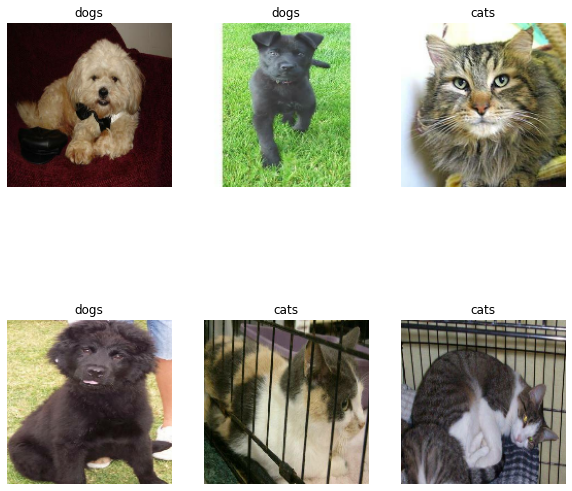

In [7]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(6):
    ax = plt.subplot(2, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


In [8]:
def class_vis(train_dataset):
  plt.figure(figsize=(10, 10))
  counter = 0
  for images, labels in train_dataset.take(1):
    for i in range(BATCH_SIZE):
      if labels[i] == 0:
        ax = plt.subplot(2, 3, counter + 1)
        counter += 1
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title("cats")
        plt.axis("off")
      if counter == 3:      # the first row (first three pictures) only print cats
        break
    for j in range(BATCH_SIZE):
      if labels[j] == 1:
        ax = plt.subplot(2, 3, counter + 1)
        counter += 1
        plt.imshow(images[j].numpy().astype("uint8"))
        plt.title("dogs")
        plt.axis("off")
      if counter == 6:      # the second row (last three pictures) only print dogs
        break
    if counter == 6:
      break
  
  return ax

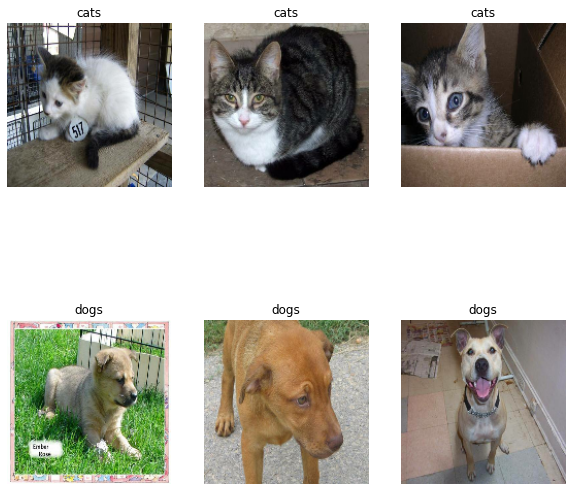

In [9]:
class_vis(train_dataset)

Before we start train our model, we create an iterator called `labels`.

We can use it to compute the number of images in the training data with label `0` (`cats`) and label `1` (`dogs`).

In [10]:
labels_iterator = train_dataset.unbatch().map(lambda image, label: label).as_numpy_iterator()

In [11]:
counter1 = 0
counter2 = 0
for element in labels_iterator:
  if element == 0:
    counter1 += 1
  else:
    counter2 += 1

print(f"cats: {counter1} \ndogs: {counter2}")

cats: 1000 
dogs: 1000


The baseline machine learning model is the model that always guesses the most frequent label.

Since the number of hte images of cats and the images of dogs in the dataset are 1000 for each, the accuracy of baseline model would be **50%** in our case.

We will create a model which can do much better than the baseline model next.

# §2. Training and improving our model

## Model 1 (Initial model)

In the beginning, we create a `tf.keras.Sequential` model by using the following layers: 
- `Conv2D`
- `MaxPooling2D`
- `GlobalAveragePooling2D`
- `Dropout` 
- `Flatten`
- `Dense`


In [19]:
model1 = tf.keras.Sequential([
                              # learn a total of 32 filters
                              layers.Conv2D(32, (3, 3), activation='relu', input_shape=(160, 160, 3)), 
                              layers.Conv2D(32, (3, 3), activation='relu'),
                              layers.MaxPooling2D((2, 2)),         # reduce the spatial dimensions of the output volume
                              
                              # # learn a total of 64 filters
                              layers.Conv2D(64, (3, 3), activation='relu'),
                              layers.Conv2D(64, (3, 3), activation='relu'),
                              layers.MaxPooling2D((2, 2)),

                              # learn a total of 128 filters
                              layers.Conv2D(128, (3, 3), activation='relu'),
                              layers.Conv2D(128, (3, 3), activation='relu'),
                              layers.MaxPooling2D((2, 2)),

                              # global average pooling operation for spatial data
                              layers.GlobalAveragePooling2D(),

                              # layers.Dropout() help your network generalize and not overfit
                              # randomly selected 30% of neurons from the neural network and drop them out
                              layers.Dropout(0.3), 

                              # Flattens the input and does not affect the batch size            
                              layers.Flatten(),
                              
                              layers.Dense(128, activation='relu'),
                              layers.Dense(8, activation='softmax')      
])

Let's take a look the overview of model1.

In [20]:
model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 158, 158, 32)      896       
                                                                 
 conv2d_7 (Conv2D)           (None, 156, 156, 32)      9248      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 78, 78, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 76, 76, 64)        18496     
                                                                 
 conv2d_9 (Conv2D)           (None, 74, 74, 64)        36928     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 37, 37, 64)       0         
 2D)                                                  

Then, we will do the model training. 

Compile the model by specifying the loss function and optimization algorithm. Since we used `softmax` activation, our loss function should be `'sparse_categorical_crossentropy'`. If we used `sigmoid` activation, then `'binary_crossentropy'` is the loss parameter.

Now, ready for training!

In [21]:
model1.compile(optimizer = "adam",
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])      # control which model performance measures are shown when training or evaluating the model

history = model1.fit(train_dataset, 
                     epochs=20, 
                     validation_data=validation_dataset)

Epoch 1/20
63/63 [==============================] - 11s 162ms/step - loss: 0.9530 - accuracy: 0.5085 - val_loss: 0.6989 - val_accuracy: 0.4938
Epoch 2/20
63/63 [==============================] - 10s 154ms/step - loss: 0.7017 - accuracy: 0.5250 - val_loss: 0.6921 - val_accuracy: 0.5173
Epoch 3/20
63/63 [==============================] - 10s 154ms/step - loss: 0.7082 - accuracy: 0.5030 - val_loss: 0.6923 - val_accuracy: 0.4988
Epoch 4/20
63/63 [==============================] - 10s 153ms/step - loss: 0.7096 - accuracy: 0.5315 - val_loss: 0.7120 - val_accuracy: 0.4938
Epoch 5/20
63/63 [==============================] - 10s 154ms/step - loss: 0.6984 - accuracy: 0.5280 - val_loss: 0.6766 - val_accuracy: 0.5347
Epoch 6/20
63/63 [==============================] - 10s 153ms/step - loss: 0.6978 - accuracy: 0.5150 - val_loss: 0.6840 - val_accuracy: 0.5569
Epoch 7/20
63/63 [==============================] - 10s 155ms/step - loss: 0.6930 - accuracy: 0.5365 - val_loss: 0.6859 - val_accuracy: 0.5433

Show the training history of this model, including the training and validation performance.

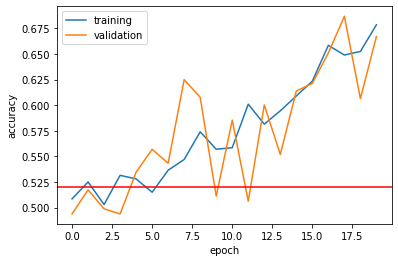

In [22]:
plt.plot(history.history["accuracy"], label = "training")
plt.plot(history.history["val_accuracy"], label = "validation")
plt.gca().set(xlabel = "epoch", ylabel = "accuracy")
plt.axhline(y=0.52, color = "red", linestyle = "-").        # baseline
plt.legend()

**The validation accuracy of `model1` stabilized between 60% and 65% during training.**

Compare to the baseline_model, model1 is around **10%** higher.

And, there is **no overfitting** in `model1`.

## Model 2 (Model with Data Augmentation)

Data augmentation refers to the practice of including modified copies of the same image in the training set. For example, a picture of a cat is still a picture of a cat even if we flip it upside down or rotate it 90 degrees. We can include such transformed versions of the image in our training process in order to help our model learn so-called invariant features of our input images.

Now we’re going to add `data_augmentation` layers to our model, including:
- `tf.keras.layers.RandomFlip()`
- `tf.keras.layers.RandomRotation()`

In [23]:
data_augmentation = tf.keras.Sequential([
                                         layers.RandomFlip('horizontal'),   # randomly flips images horizontally
                                         layers.RandomRotation(0.2)         # randomly rotates images clockwise by a random amount in the range
])

Make a plot of the original image and a few copies to which `RandomFlip()` has been applied.

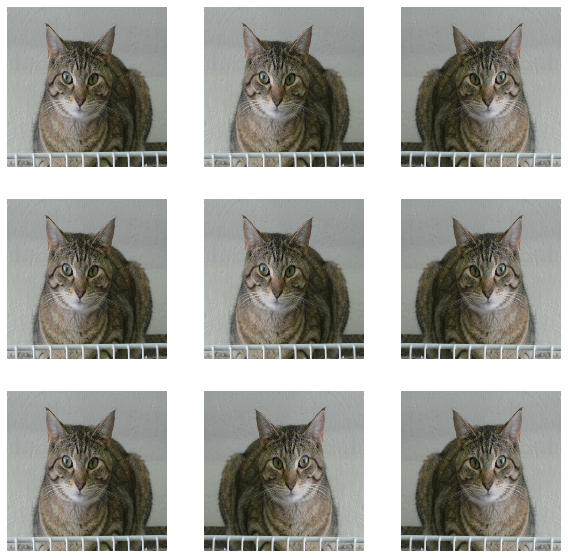

In [24]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = layers.RandomFlip('horizontal')(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

Similarly, make a plot using `RandomRotation()`.

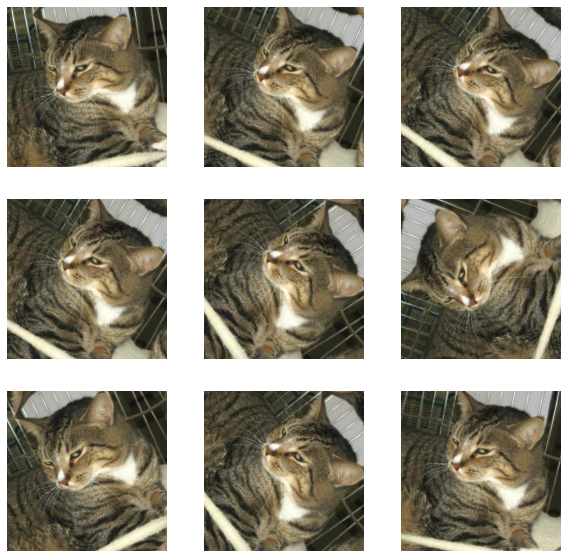

In [25]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = layers.RandomRotation(0.2)(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

Now, create a new `tf.keras.models.Sequential` model called `model2` based on `model1` in which the first two layers are `data_augmentation` layers. 

In [26]:
model2 = tf.keras.Sequential([
                              data_augmentation,
                              model1
])

In [29]:
model2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 160, 160, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 8)                 304552    
                                                                 
Total params: 304,552
Trainable params: 304,552
Non-trainable params: 0
_________________________________________________________________


Train our model2.

In [28]:
model2.compile(optimizer = "adam",
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])

history = model2.fit(train_dataset, 
                     epochs=20, 
                     validation_data=validation_dataset)

Epoch 1/20
63/63 [==============================] - 12s 163ms/step - loss: 0.6475 - accuracy: 0.6400 - val_loss: 0.6794 - val_accuracy: 0.5557
Epoch 2/20
63/63 [==============================] - 10s 159ms/step - loss: 0.6439 - accuracy: 0.6430 - val_loss: 0.6231 - val_accuracy: 0.6683
Epoch 3/20
63/63 [==============================] - 10s 159ms/step - loss: 0.6166 - accuracy: 0.6765 - val_loss: 0.6371 - val_accuracy: 0.6300
Epoch 4/20
63/63 [==============================] - 10s 159ms/step - loss: 0.6212 - accuracy: 0.6565 - val_loss: 0.5987 - val_accuracy: 0.6807
Epoch 5/20
63/63 [==============================] - 10s 159ms/step - loss: 0.6002 - accuracy: 0.6675 - val_loss: 0.5860 - val_accuracy: 0.6832
Epoch 6/20
63/63 [==============================] - 10s 157ms/step - loss: 0.5899 - accuracy: 0.6800 - val_loss: 0.5799 - val_accuracy: 0.6918
Epoch 7/20
63/63 [==============================] - 10s 159ms/step - loss: 0.6383 - accuracy: 0.6465 - val_loss: 0.6157 - val_accuracy: 0.6708

Visualize the training history.

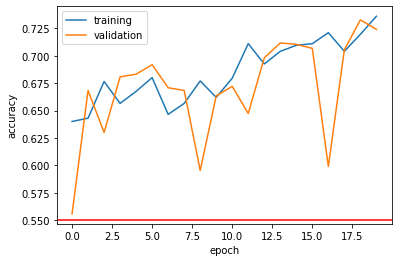

In [30]:
plt.plot(history.history["accuracy"], label = "training")
plt.plot(history.history["val_accuracy"], label = "validation")
plt.gca().set(xlabel = "epoch", ylabel = "accuracy")
plt.axhline(y=0.55, color = "red", linestyle = "-")
plt.legend()

**The validation accuracy of `model2` stabilized between 65% and 70% during training.**

Compare to `model1`. the validation accuracy of `model2` is **5%** higher.

And, there is **no overfitting** in `model2`.

## Model 3 (Data Preprocessing)

It can be helpful to make simple transformations to the input data sometimes. For example, in this case, the original data has pixels with RGB values between 0 and 255, but many models will train faster with RGB values normalized between 0 and 1, or possibly between -1 and 1. These are mathematically identical situations, since we can always just scale the weights. But if we handle the scaling prior to the training process, we can spend more of our training energy handling actual signal in the data and less energy having the weights adjust to the data scale.

Let's create and add a `preprocessing` layer to our model.

In [31]:
i = tf.keras.Input(shape=(160, 160, 3))
x = tf.keras.applications.mobilenet_v2.preprocess_input(i)
preprocessor = tf.keras.Model(inputs = [i], outputs = [x])

Incorporate the `preprocessor` layer as the very first layer in our model

In [32]:
model3 = tf.keras.Sequential([
                              preprocessor,
                              model2
])

In [33]:
model3.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 160, 160, 3)       0         
                                                                 
 sequential_3 (Sequential)   (None, 8)                 304552    
                                                                 
Total params: 304,552
Trainable params: 304,552
Non-trainable params: 0
_________________________________________________________________


Train our model3.

In [36]:
model3.compile(optimizer = "adam",
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])

history = model3.fit(train_dataset, 
                     epochs=20, 
                     validation_data=validation_dataset)

Epoch 1/20
63/63 [==============================] - 12s 163ms/step - loss: 0.5550 - accuracy: 0.7230 - val_loss: 0.5537 - val_accuracy: 0.7054
Epoch 2/20
63/63 [==============================] - 10s 160ms/step - loss: 0.5289 - accuracy: 0.7425 - val_loss: 0.6308 - val_accuracy: 0.6819
Epoch 3/20
63/63 [==============================] - 10s 160ms/step - loss: 0.5238 - accuracy: 0.7440 - val_loss: 0.5622 - val_accuracy: 0.7166
Epoch 4/20
63/63 [==============================] - 10s 160ms/step - loss: 0.5157 - accuracy: 0.7450 - val_loss: 0.5787 - val_accuracy: 0.6931
Epoch 5/20
63/63 [==============================] - 10s 160ms/step - loss: 0.5005 - accuracy: 0.7585 - val_loss: 0.5568 - val_accuracy: 0.7314
Epoch 6/20
63/63 [==============================] - 10s 159ms/step - loss: 0.5006 - accuracy: 0.7585 - val_loss: 0.5519 - val_accuracy: 0.7203
Epoch 7/20
63/63 [==============================] - 10s 159ms/step - loss: 0.5120 - accuracy: 0.7395 - val_loss: 0.5781 - val_accuracy: 0.7191

Visualize the training history.

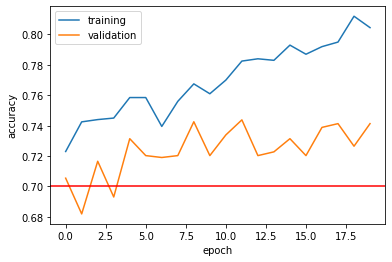

In [37]:
plt.plot(history.history["accuracy"], label = "training")
plt.plot(history.history["val_accuracy"], label = "validation")
plt.gca().set(xlabel = "epoch", ylabel = "accuracy")
plt.axhline(y=0.7, color = "red", linestyle = "-")
plt.legend()

**The validation accuracy of `model3` stabilized between 70% and 72% during training.**

Compare to `model2`. the validation accuracy of `model3` is **3%** higher.

But, there is **overfitting** in `model3`.

## Model 4 (Transfer Learning)

So far, we’ve been training models for distinguishing between cats and dogs from scratch. In some cases, however, someone might already have trained a model that does a related task, and might have learned some relevant patterns. For example, folks train machine learning models for a variety of image recognition tasks. Maybe we could use a pre-existing model for our task?

To do this, we need to first access a pre-existing “base model”, incorporate it into a full model for our current task, and then train that model.

Paste the following code in order to download `MobileNetV2` and configure it as a layer that can be included in our model.

In [38]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False

i = tf.keras.Input(shape=IMG_SHAPE)
x = base_model(i, training = False)
base_model_layer = tf.keras.Model(inputs = [i], outputs = [x])

9420800/9406464 [==============================] - 0s 0us/step


Create our model4 by the ordering layers showing below:
1. `preprocessor` 
2. `data_augmentation` 
3. `base_model_layer` 
4. `Dense(2)` (at the very end to actually perform the classification)

In [39]:
model4 = tf.keras.Sequential([
                              preprocessor,

                              data_augmentation,

                              base_model_layer,

                              layers.GlobalAveragePooling2D(),

                              layers.Dropout(0.5),
                              layers.Flatten(),
                              layers.Dense(128, activation='relu'),
                              layers.Dense(2, activation='softmax')  # there are only 2 classes, cats and dogs
])

In [40]:
model4.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 160, 160, 3)       0         
                                                                 
 sequential_2 (Sequential)   (None, 160, 160, 3)       0         
                                                                 
 model_1 (Functional)        (None, 5, 5, 1280)        2257984   
                                                                 
 global_average_pooling2d_2   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_2 (Dropout)         (None, 1280)              0         
                                                                 
 flatten_2 (Flatten)         (None, 1280)              0         
                                                      

By checking `model4.summary`, we can see there are total **2,422,210** parameters that we have to train in this model.

Train our model4.

In [41]:
model4.compile(optimizer = "adam",
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])

history = model4.fit(train_dataset, 
                     epochs=20, 
                     validation_data=validation_dataset)

Epoch 1/20
63/63 [==============================] - 12s 116ms/step - loss: 0.2704 - accuracy: 0.8930 - val_loss: 0.0771 - val_accuracy: 0.9740
Epoch 2/20
63/63 [==============================] - 6s 90ms/step - loss: 0.1899 - accuracy: 0.9345 - val_loss: 0.0665 - val_accuracy: 0.9752
Epoch 3/20
63/63 [==============================] - 6s 92ms/step - loss: 0.1806 - accuracy: 0.9280 - val_loss: 0.0540 - val_accuracy: 0.9827
Epoch 4/20
63/63 [==============================] - 6s 91ms/step - loss: 0.1252 - accuracy: 0.9480 - val_loss: 0.0528 - val_accuracy: 0.9790
Epoch 5/20
63/63 [==============================] - 6s 91ms/step - loss: 0.1540 - accuracy: 0.9370 - val_loss: 0.0616 - val_accuracy: 0.9765
Epoch 6/20
63/63 [==============================] - 6s 91ms/step - loss: 0.1176 - accuracy: 0.9470 - val_loss: 0.0494 - val_accuracy: 0.9777
Epoch 7/20
63/63 [==============================] - 6s 92ms/step - loss: 0.1053 - accuracy: 0.9550 - val_loss: 0.0481 - val_accuracy: 0.9814
Epoch 8/20


Visualize the training history.

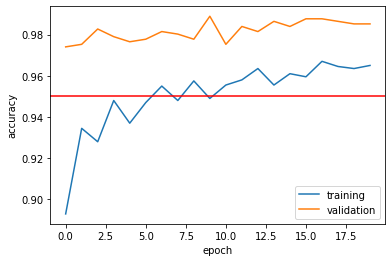

In [42]:
plt.plot(history.history["accuracy"], label = "training")
plt.plot(history.history["val_accuracy"], label = "validation")
plt.gca().set(xlabel = "epoch", ylabel = "accuracy")
plt.axhline(y=0.95, color = "red", linestyle = "-")
plt.legend()

**The validation accuracy of `model4` stabilized around 98% during training, which is amazing **

Compare to `model3`. the validation accuracy of `model4` is much higher.

And, there is **no overfitting** in `model3`.

# Score on Test Data

Evaluate the accuracy of our most performant model, model4, on the unseen `test_dataset`.

In [45]:
model4.evaluate(test_dataset)

6/6 [==============================] - 1s 69ms/step - loss: 0.0296 - accuracy: 0.9948


[0.029649347066879272, 0.9947916865348816]

We still get a 99% accuracy when evaluating our best model on the test dataset. Great job!